# 1. Подготовка данных

In [30]:
import warnings

# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# DATASET = r'dataset\\Первичная выгрузка Станки Загрузка по дням.xlsx'
DATASET = r'dataset\\signal_data_full.xlsx'

In [33]:
df = pd.read_excel(DATASET)

In [34]:
# df.drop(df.tail(1).index,inplace=True, errors='ignore')
# df.drop(['Объект'], axis=1, inplace=True, errors='ignore')

In [35]:
 # drop last n rows
# df.drop(columns=['Качество', 'Станок под нагрузкой', 'OEE'], inplace=True)

In [36]:
df.fillna(0, inplace=True)
# df.interpolate(method='linear', inplace=True)

In [37]:
# df = pd.get_dummies(df, columns=['Объект'], drop_first=True)
df.drop(columns=['Объект'], inplace=True)

In [38]:
# df = df[df["Дата"] >= "2023-01-01"].reset_index(drop=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95809 entries, 0 to 95808
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Дата                        95809 non-null  object 
 1   M00 останов                 95809 non-null  float64
 2   M01 останов                 95809 non-null  float64
 3   Аварийная остановка         95809 non-null  float64
 4   Авария                      95809 non-null  float64
 5   Блокировка подачи           95809 non-null  float64
 6   Контроль ОТК                95809 non-null  float64
 7   Наладка                     95809 non-null  float64
 8   Отработка программы         95809 non-null  float64
 9   Отсутствие заготовки        95809 non-null  float64
 10  Отсутствие инструмента      95809 non-null  float64
 11  Отсутствие КД/модели        95809 non-null  float64
 12  Отсутствие программы        95809 non-null  float64
 13  Перерыв                     958

In [40]:
df['Дата'] = pd.to_datetime(df['Дата']).dt.normalize()

In [41]:
df.set_index('Дата', inplace=True)

In [42]:
df_agg = df.groupby('Дата').sum()

In [43]:
df_agg["ВП"] = df_agg["Серийное производство"] + df_agg["Программа выполняется"]
df_agg["ВРО"] = df_agg["ВП"] + df_agg["Прогрев станка"] + df_agg["Отработка программы"] + df_agg["Ручной режим"] + df_agg["Станок включен"]

df_agg["ВРП"] = df_agg["ВРО"] + df_agg["Наладка"] + df_agg["Контроль ОТК"]+ df_agg["Регламентированный перерыв"]+ df_agg["Уборка оборудования"]+ df_agg["Сервисное обслуживание"]+ df_agg["Отсутствие заготовки"]+ df_agg["Отсутствие программы"]+ df_agg["Отсутствие инструмента"]+ df_agg["Отсутствие КД/модели"]+ df_agg["Ремонтные работы"]+ df_agg["Авария"]+ df_agg["Аварийная остановка"]

df_agg["OEE"] = df_agg["ВРО"] / df_agg["ВРП"] * df_agg["ВП"] / df_agg["ВРО"] * 0.95

In [44]:
exclude_columns = ["Производительность", "Доступность", "ВРО", "ВРП", "ВП"]
df_agg.drop(exclude_columns, axis=1, inplace=True, errors="ignore")

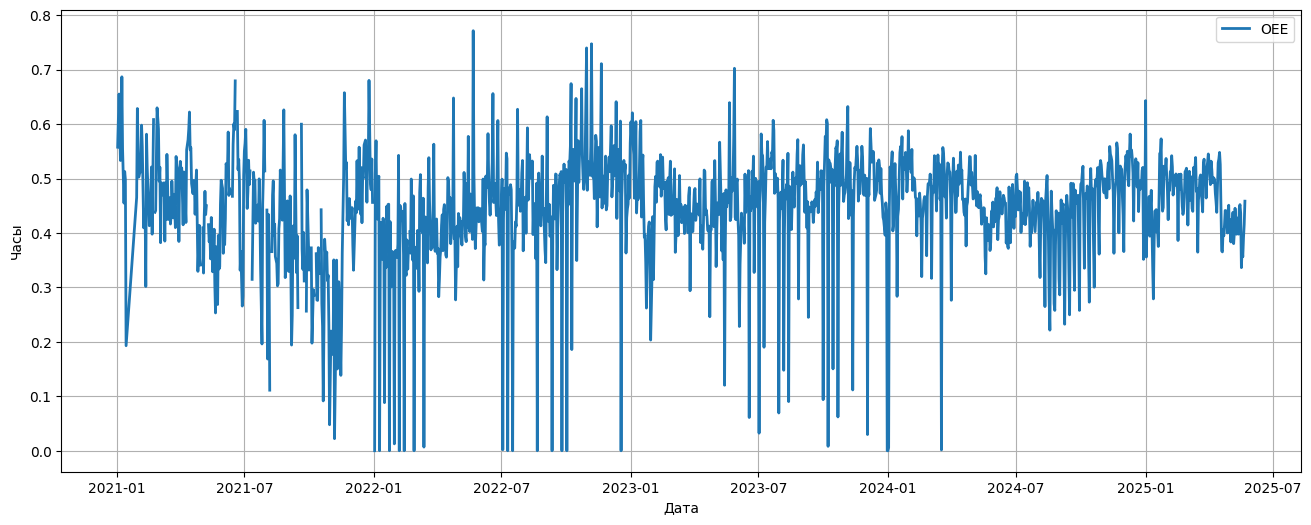

In [45]:
# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_agg.index, df_agg['OEE'], label="OEE", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# df_cleaned = df_agg.copy()

In [47]:
# Рассчитываем порог для NaN и 0
threshold = len(df_agg) * 0.7
# Удаляем столбцы, где количество NaN или 0 больше 50%
columns_0_more_20_per = [
    col
    for col in df_agg.columns
    if df_agg[col].isna().sum() > threshold or (df_agg[col] == 0).sum() > threshold
]

In [48]:

df_cleaned = df_agg.drop(columns=columns_0_more_20_per)

In [49]:
# cols = df_cleaned.columns.to_list()
# cols.remove('OEE')
# for col in cols:
#     df[col] = df[col].replace(0, 0.001)

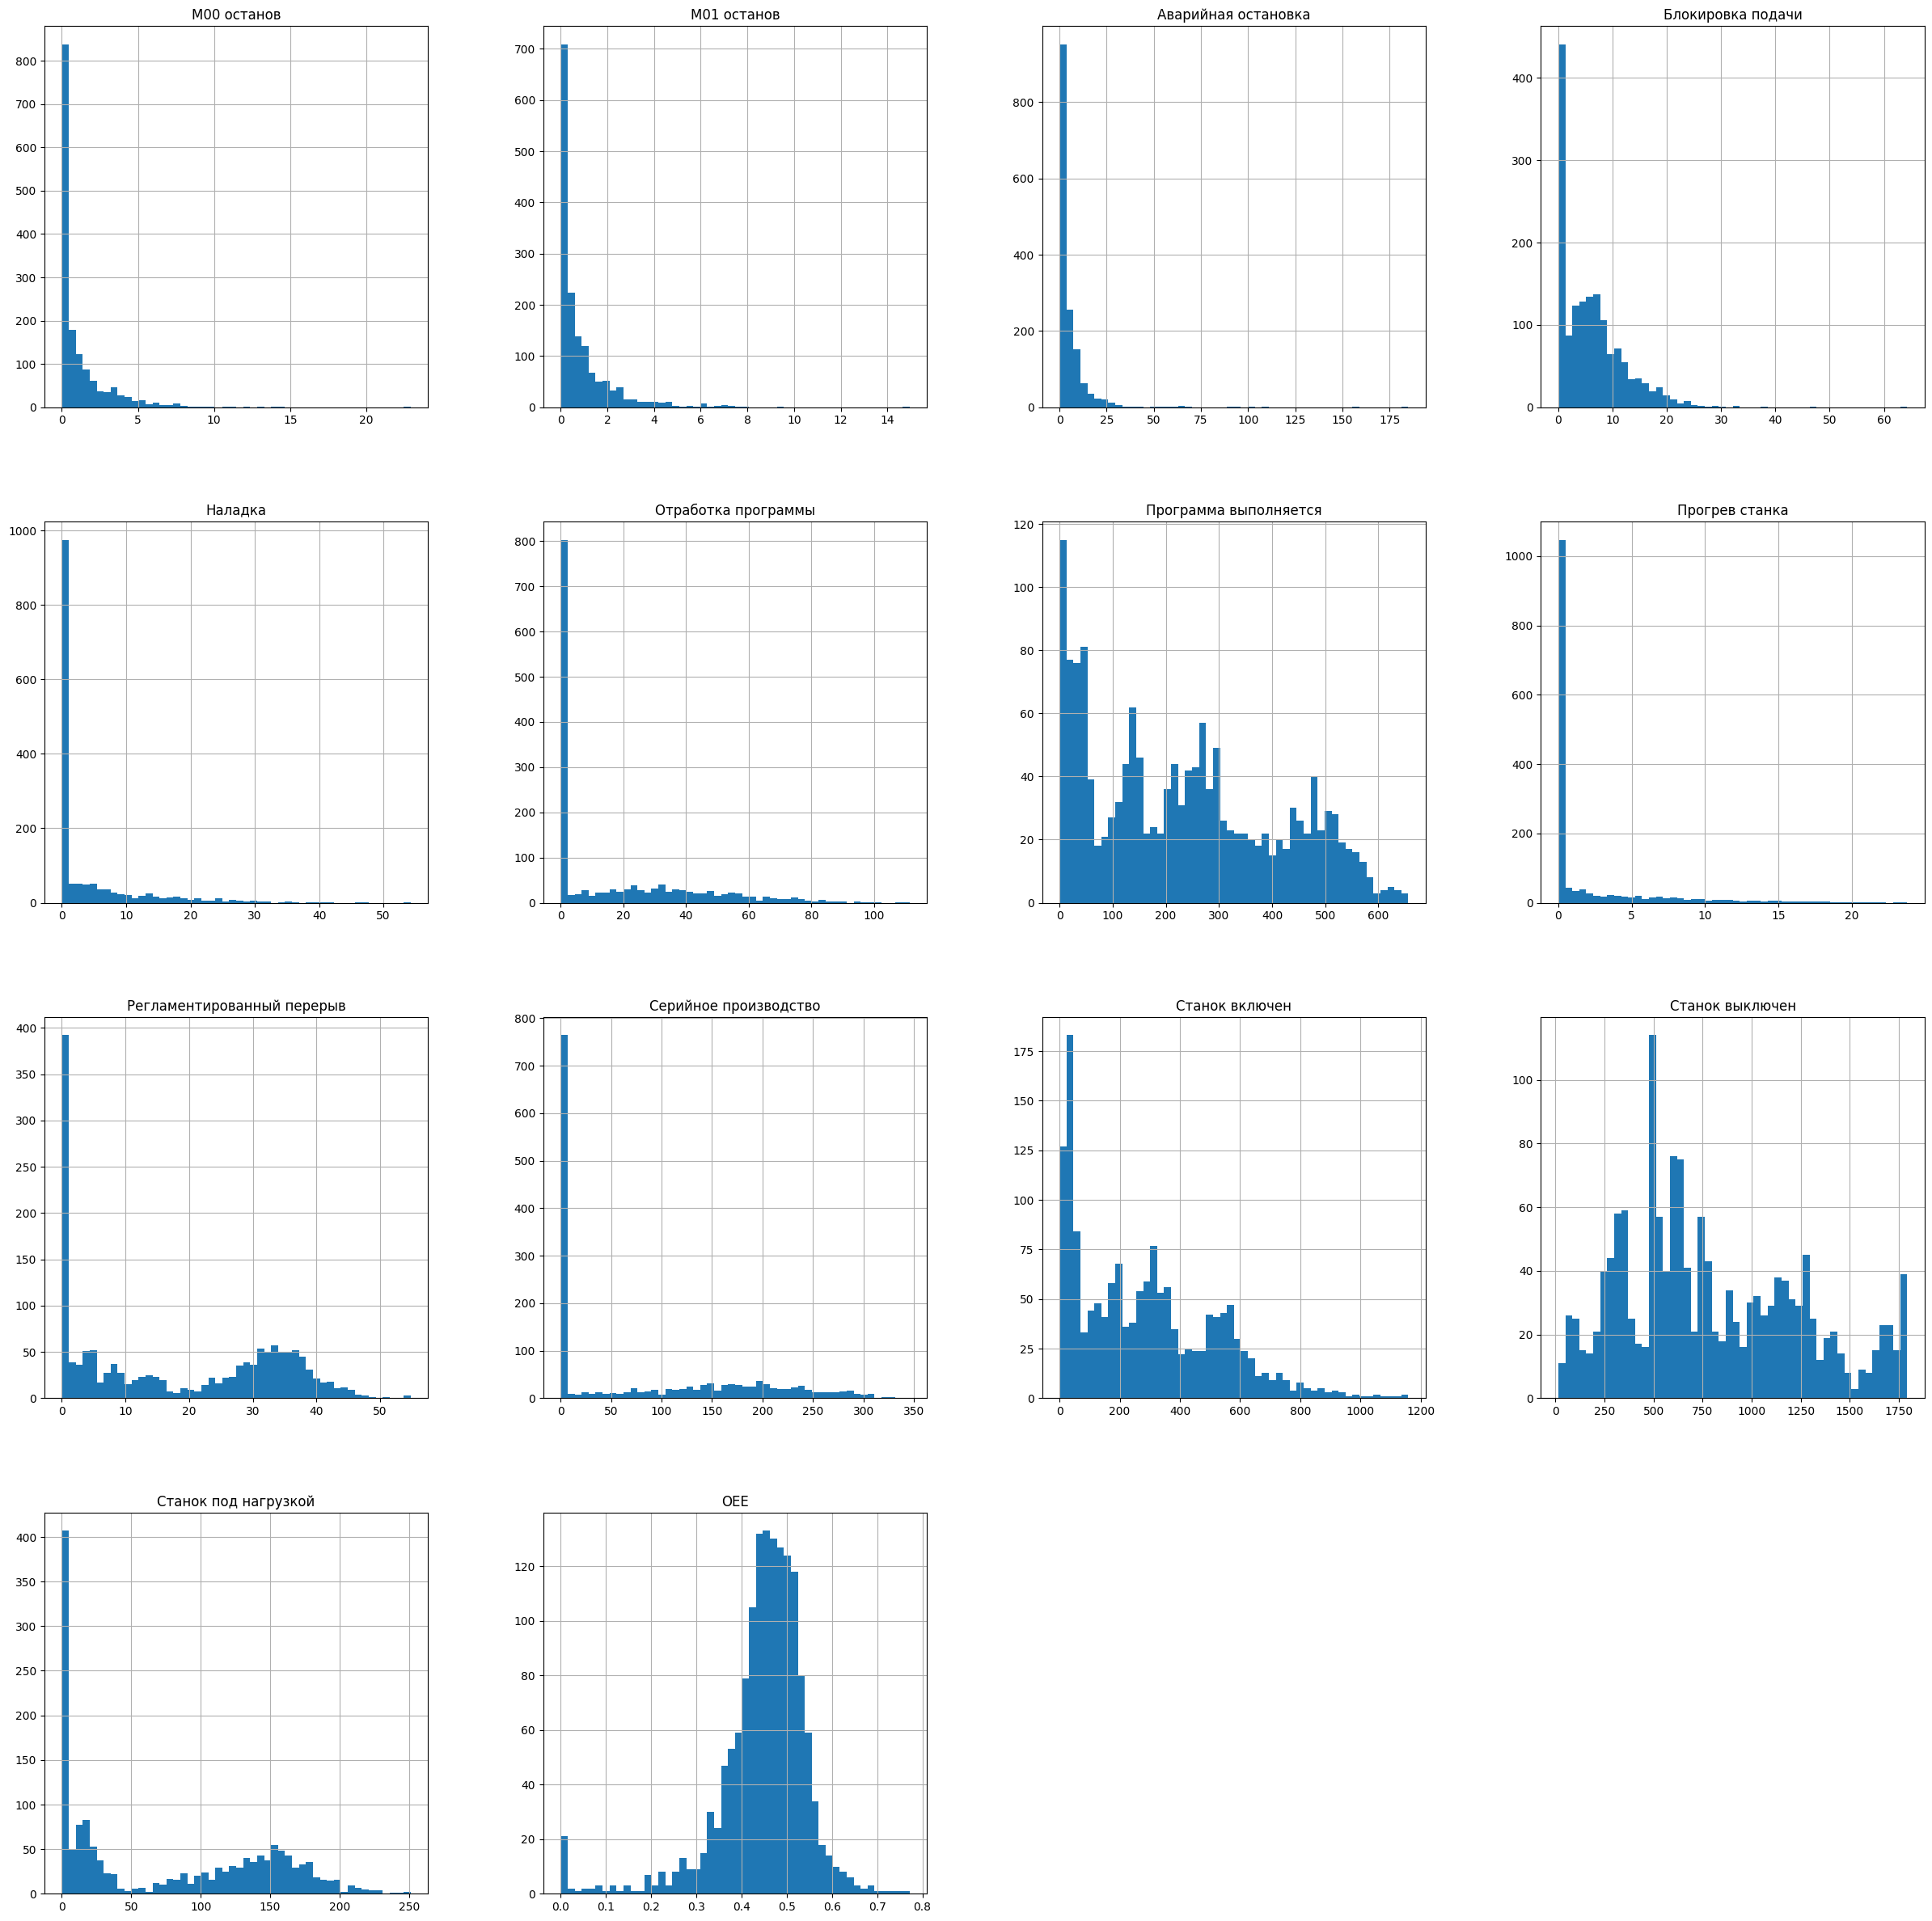

In [50]:
# Теперь df_cleaned содержит только те столбцы, где количество NaN и 0 не превышает 50%
df_cleaned.hist(bins=50, figsize=(30, 30));

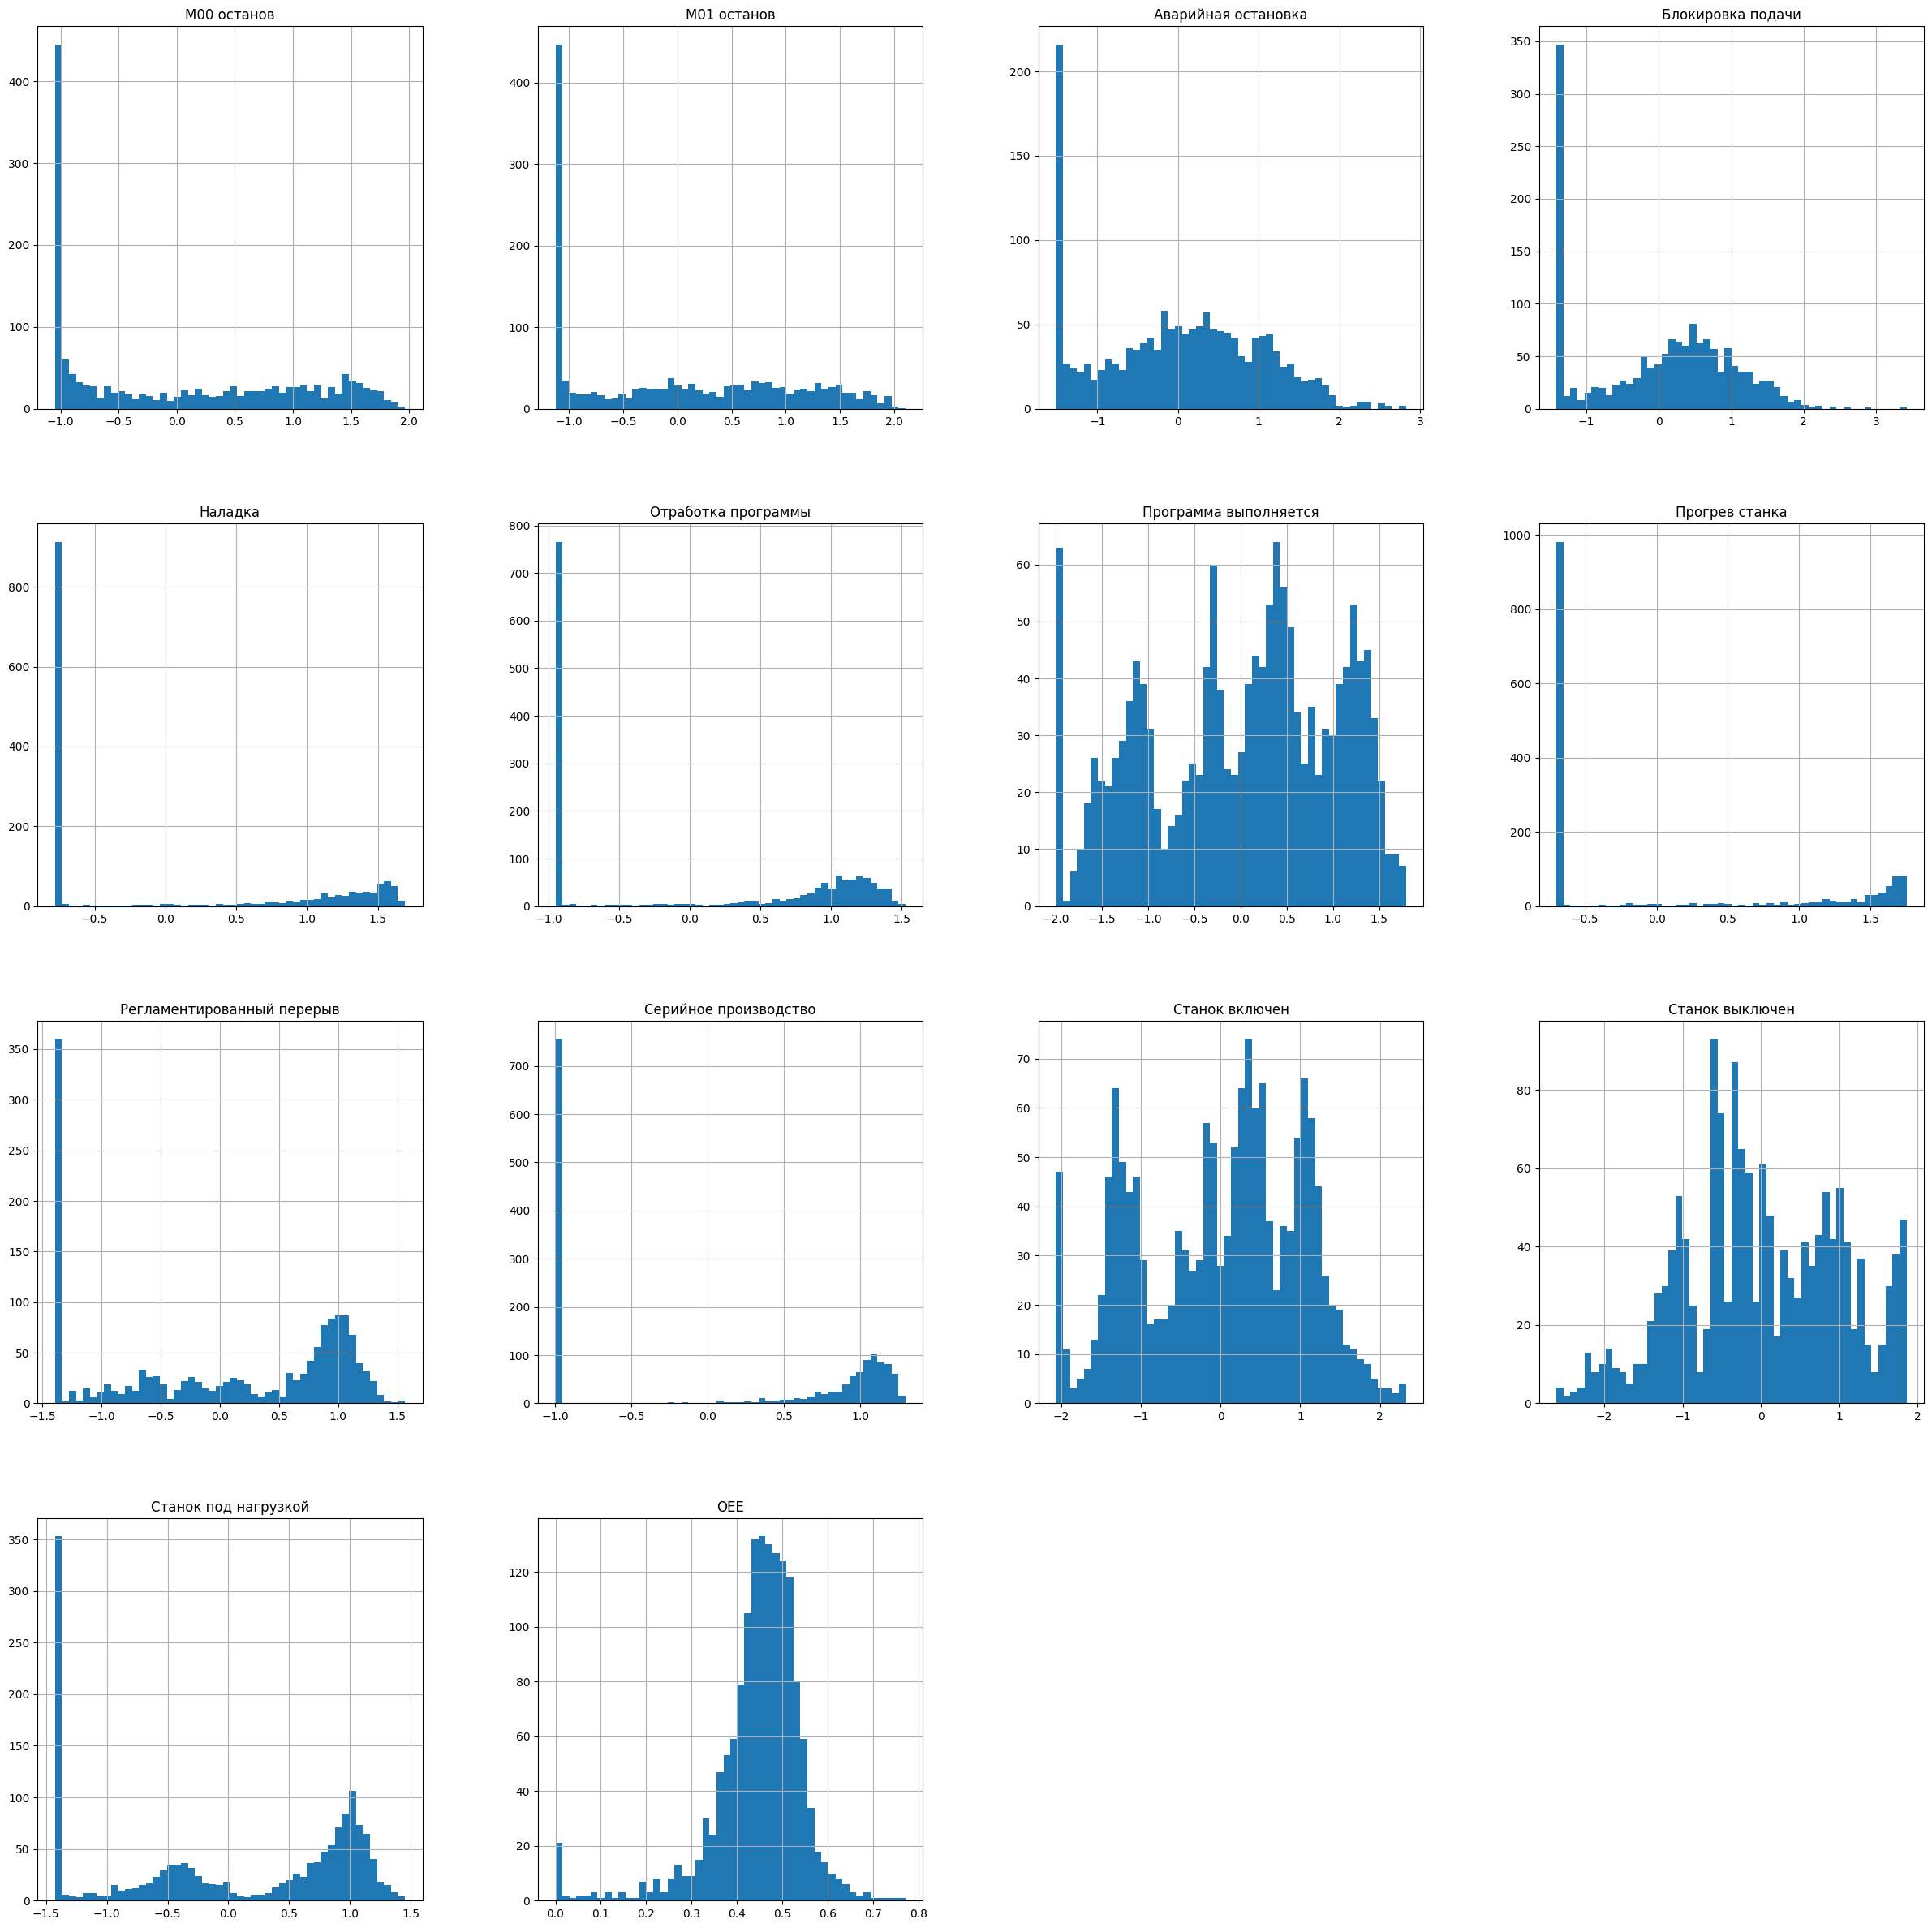

In [51]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df_cleaned[df_cleaned.drop(["OEE"], axis=1).columns] = pt.fit_transform(df_cleaned.drop(["OEE"], axis=1))

df_cleaned.hist(bins=50, figsize=(30, 30));

# 2. Исследовательский анализ

In [52]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

def decompose_df(df, column_names, model='additive', period=30):
    for col in column_names:
        series = df[col].dropna()
        decompose_result = seasonal_decompose(series, model=model, period=period)

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"Сезонная декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()
        
def decompose_df_stl(df, column_names, seasonal=13, robust=False):
    for col in column_names:
        series = df[col].dropna()
        stl = STL(series, seasonal=seasonal, robust=robust)
        decompose_result = stl.fit()

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"STL-декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def built_acf_and_pacf(df, column_names):

    for col in column_names:
        series = df[col].dropna()  # Берем только один столбец и удаляем NaN

        # Строим ACF и PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        plot_acf(series, lags=30, ax=axes[0])  # ACF для выбора q
        axes[0].set_title("ACF - Автокорреляция")

        plot_pacf(series, lags=30, ax=axes[1])  # PACF для выбора p
        axes[1].set_title("PACF - Частичная автокорреляция")

        # Добавляем общий заголовок
        fig.suptitle(f"ACF и PACF для '{col}'", fontsize=14)

        plt.show()  # Отображаем графики

In [54]:
#Выбираем целевые переменные
target_columns = ["OEE"]

## Визуализация графика

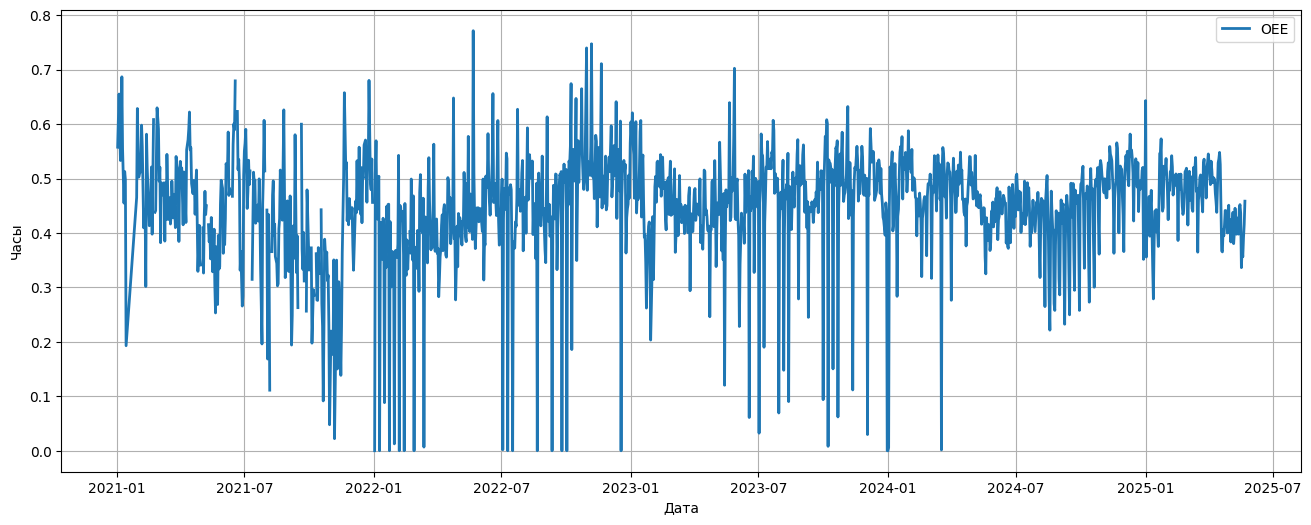

In [55]:
# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_cleaned.index, df_cleaned['OEE'], label="OEE", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.legend()
plt.grid(True)
plt.show()

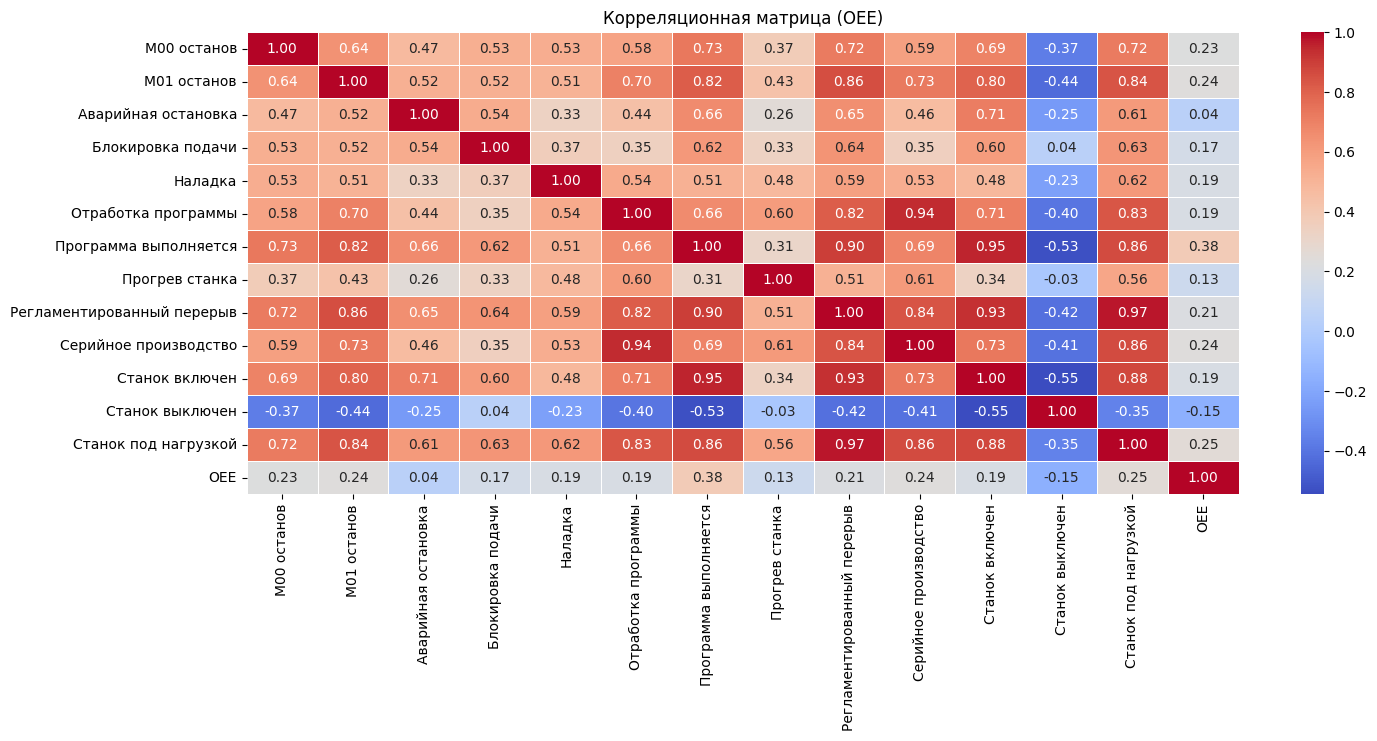

['M00 останов',
 'M01 останов',
 'Программа выполняется',
 'Регламентированный перерыв',
 'Серийное производство',
 'Станок под нагрузкой']

{'OEE': ['M00 останов',
  'M01 останов',
  'Программа выполняется',
  'Регламентированный перерыв',
  'Серийное производство',
  'Станок под нагрузкой']}

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление корреляции между целевыми и экзогенными переменными

# correlation_matrix_oee = df_cleaned[["OEE"] + df_cleaned.columns.drop(["OEE"]).to_list()].corr()

# df_cleaned.drop(labels=exclude_columns, axis=1, errors="ignore", inplace=True)
correlation_matrix_oee = df_cleaned.corr()

# Определение экзогенных переменных (корреляция > 0.2)

exog_vars_oee = correlation_matrix_oee["OEE"].drop("OEE").abs()

exog_columns_oee = exog_vars_oee[exog_vars_oee > 0.2].index.tolist()
# top_n = 10  # Количество переменных
# exog_columns_oee = exog_vars_oee.sort_values(ascending=False).head(top_n).index.tolist()

# Визуализация корреляционной матрицы для "OEE"
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_oee, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица (OEE)")
plt.show()

# Создание словаря с экзогенными переменными
exog_variables_dict = {
    "OEE": exog_columns_oee
}

# Вывод словаря
display(exog_columns_oee)
display(exog_variables_dict)

In [57]:
non_exog_columns = df_cleaned.columns.drop(exog_variables_dict['OEE']).to_list()
non_exog_columns.remove('OEE')
non_exog_columns

['Аварийная остановка',
 'Блокировка подачи',
 'Наладка',
 'Отработка программы',
 'Прогрев станка',
 'Станок включен',
 'Станок выключен']

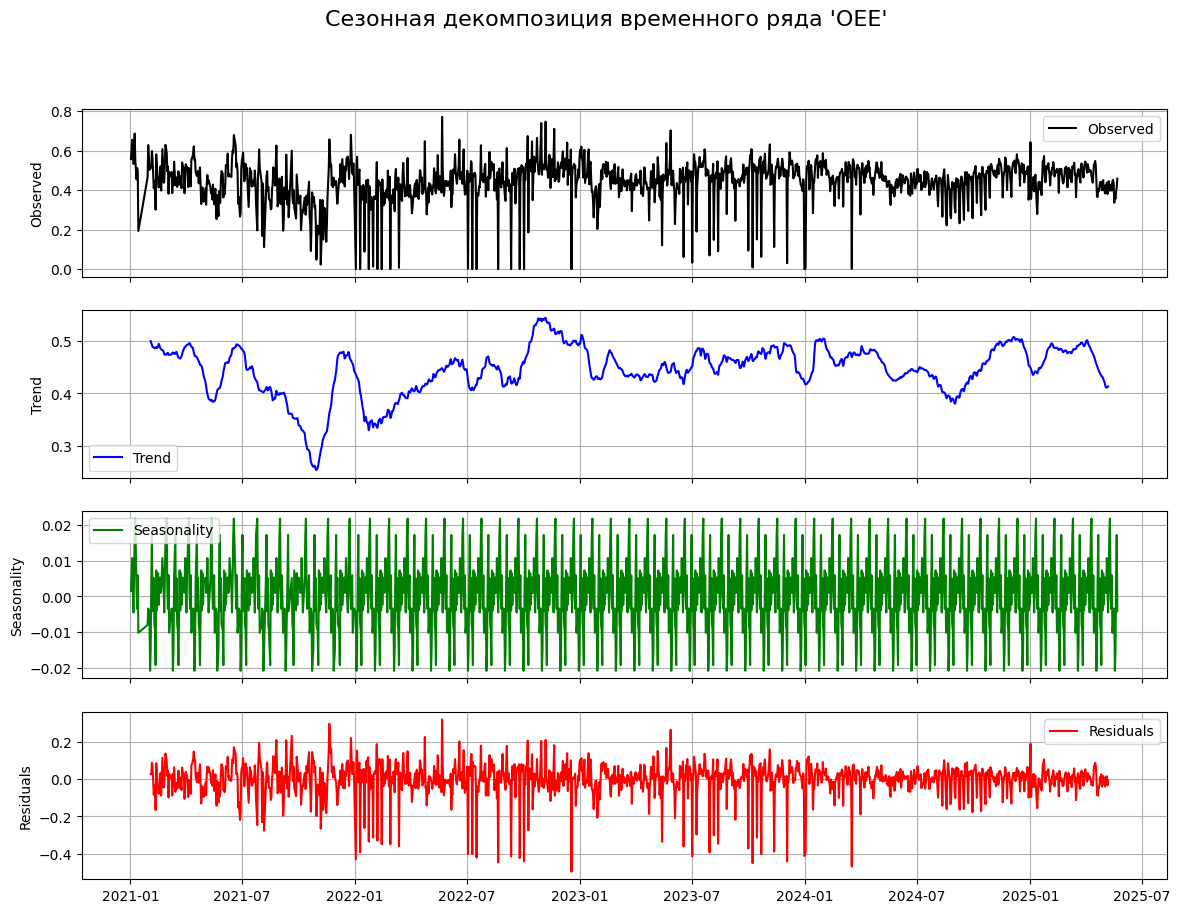

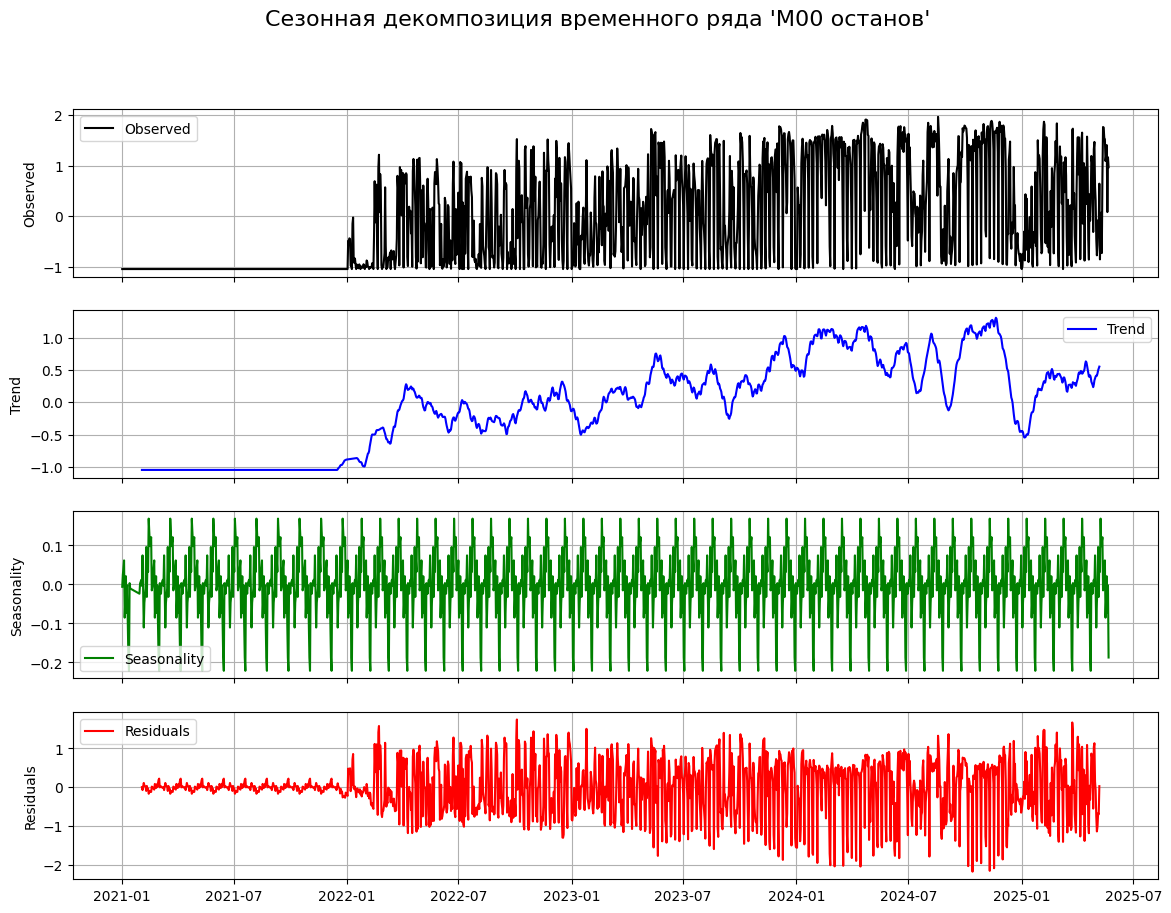

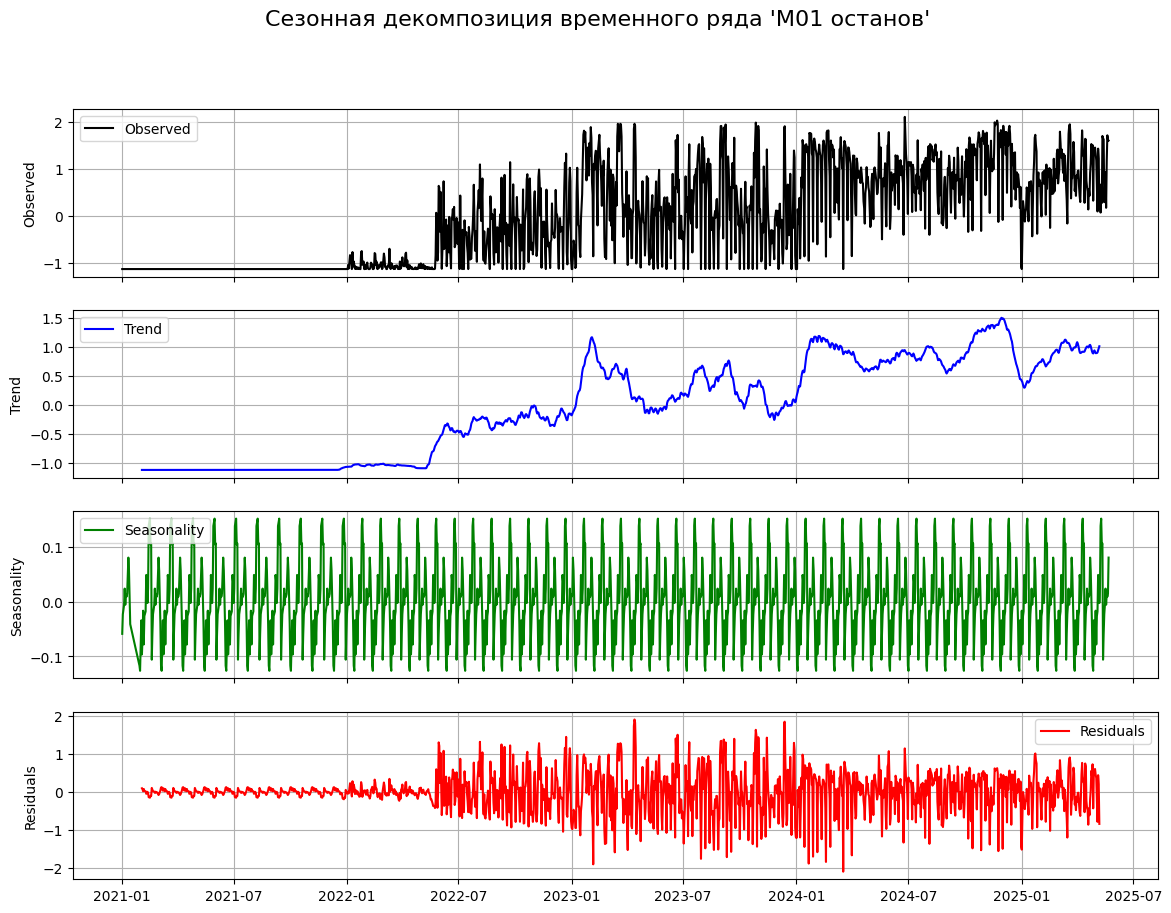

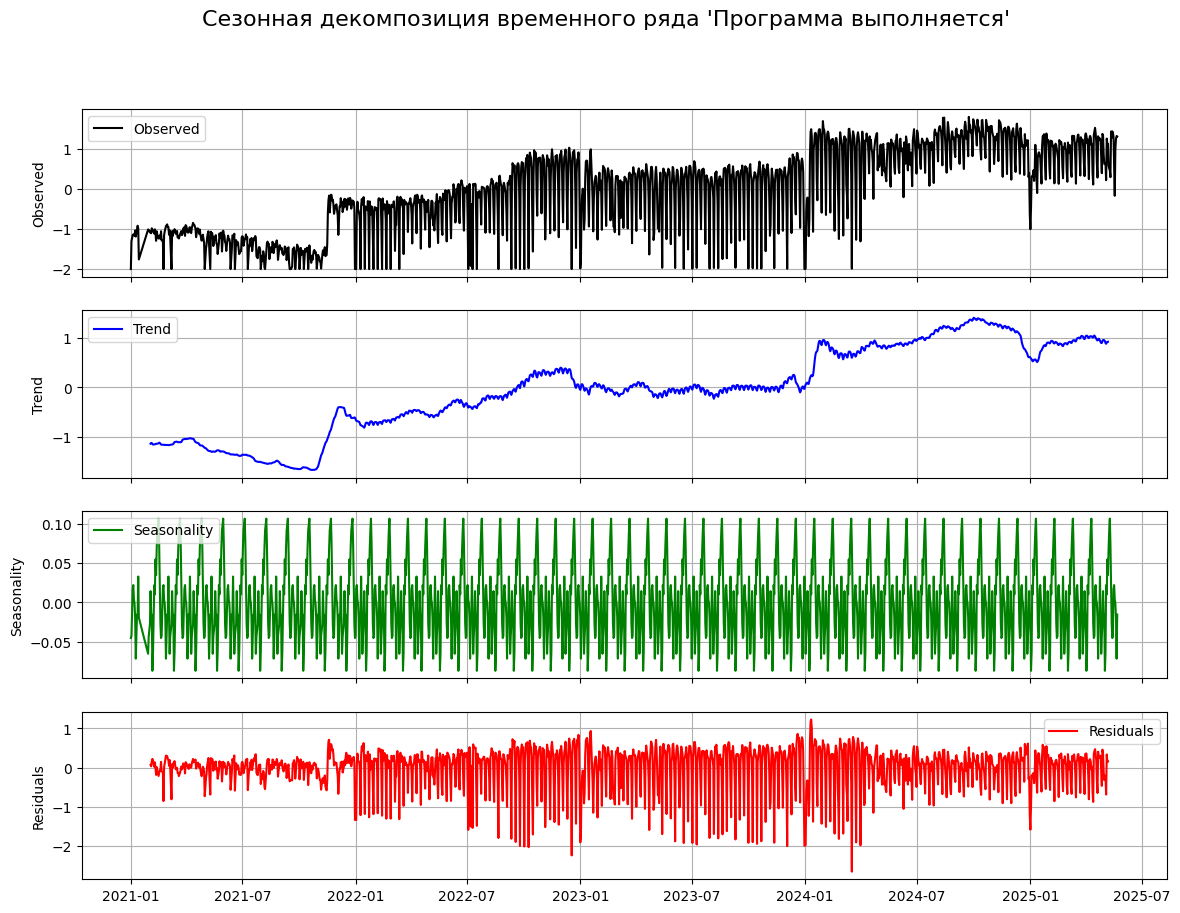

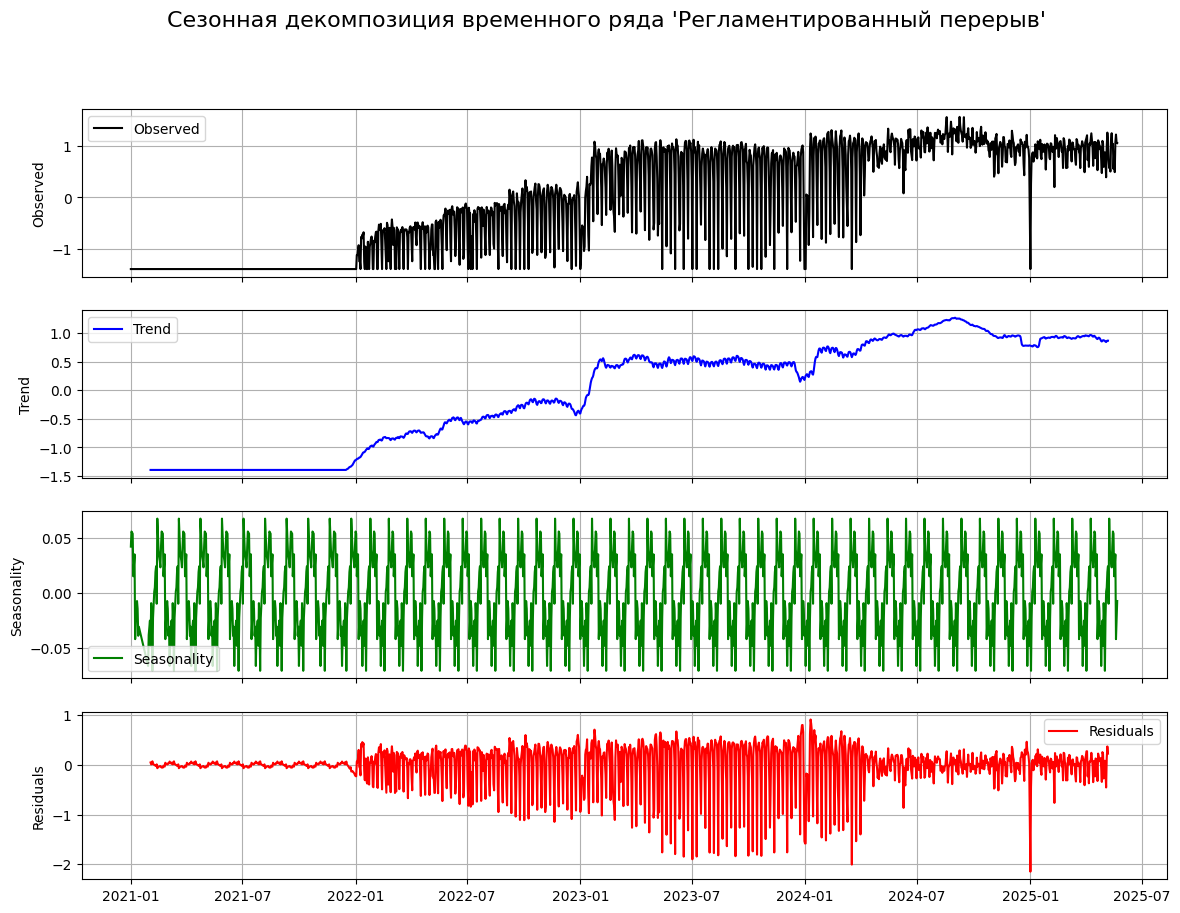

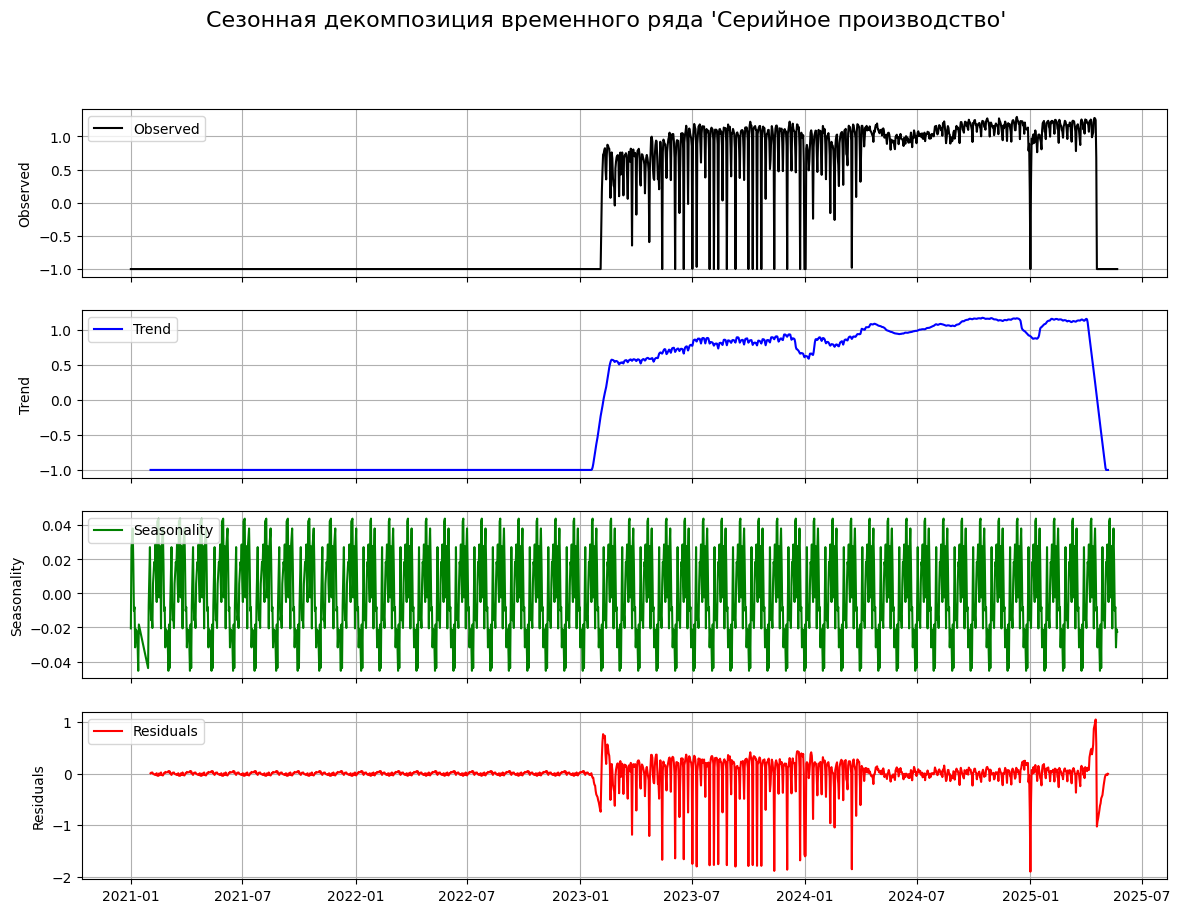

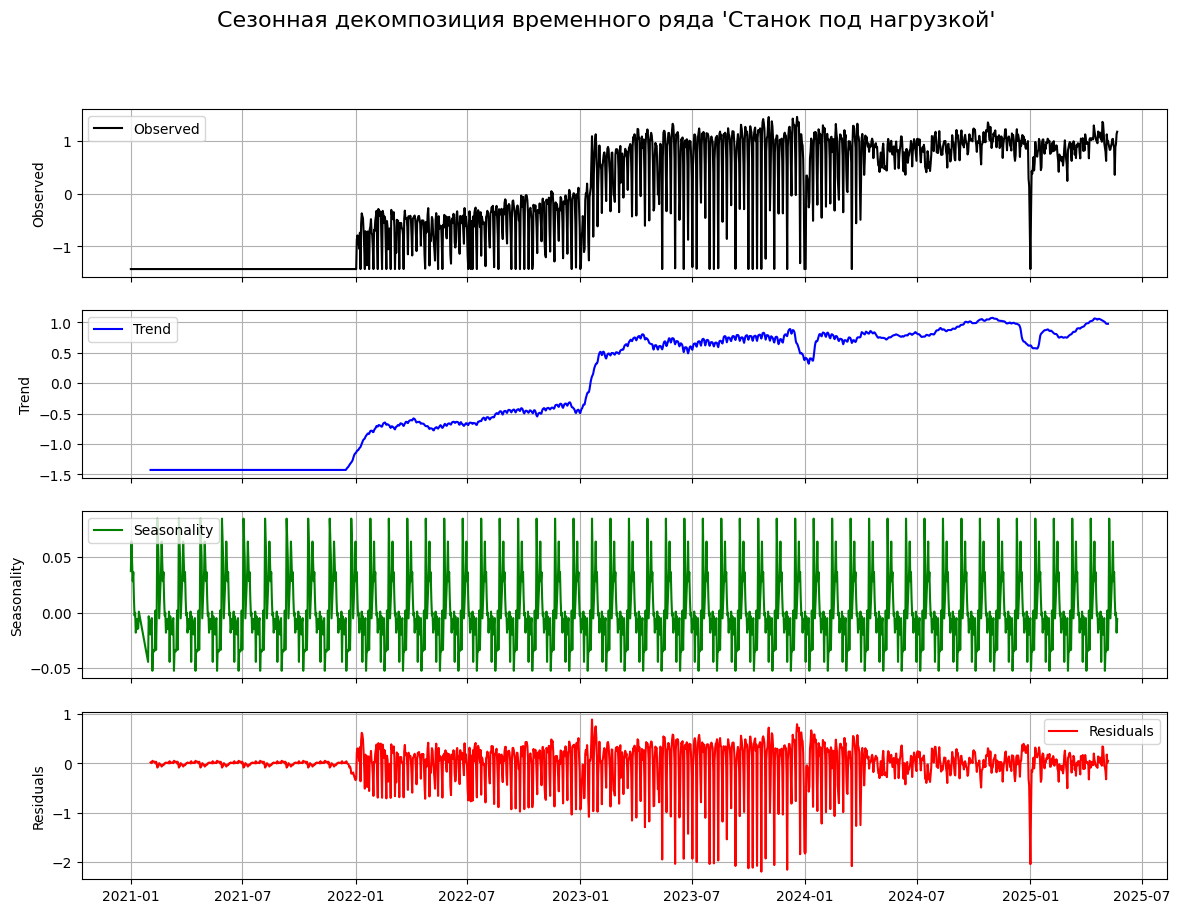

In [58]:
decompose_df(df_cleaned, target_columns)
# decompose_df_stl(df_cleaned, target_columns)

decompose_df(df_cleaned, exog_variables_dict['OEE'])
# decompose_df_stl(df_aggregated, exog_variables_dict['OEE'])

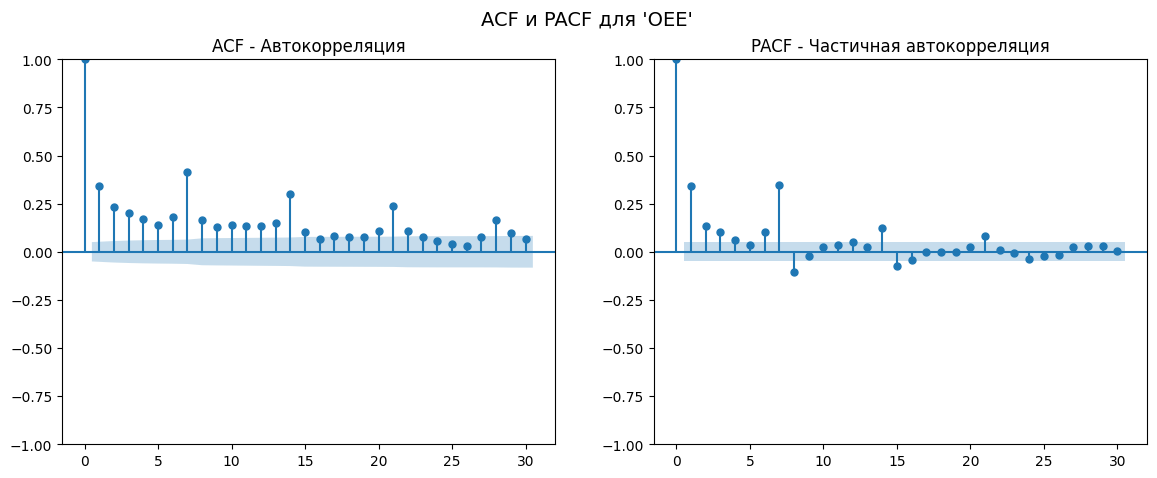

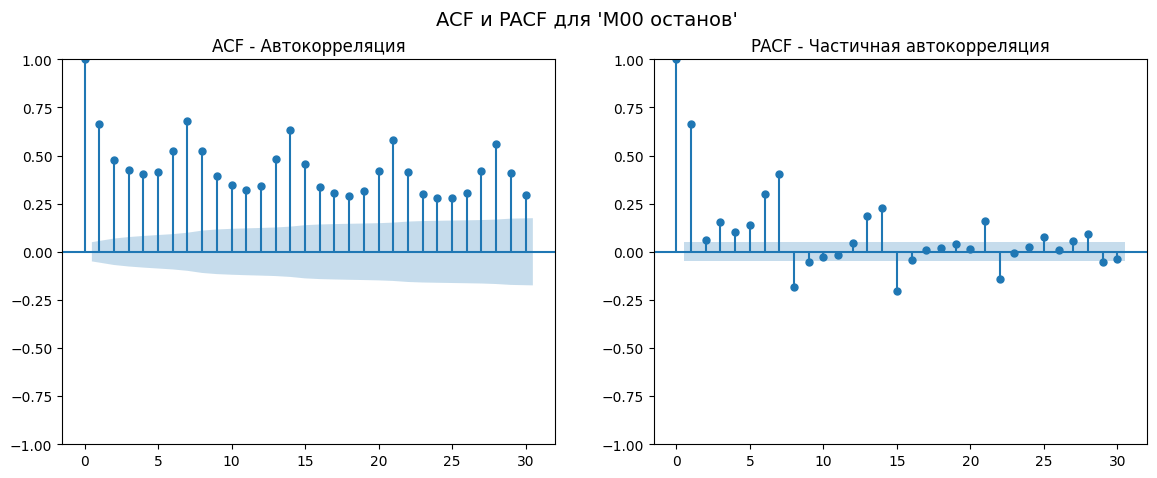

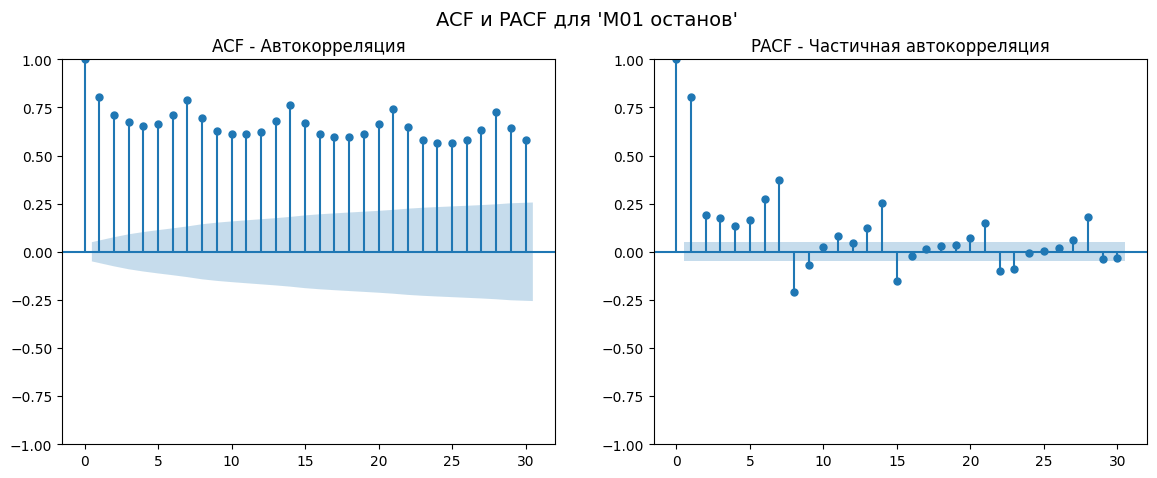

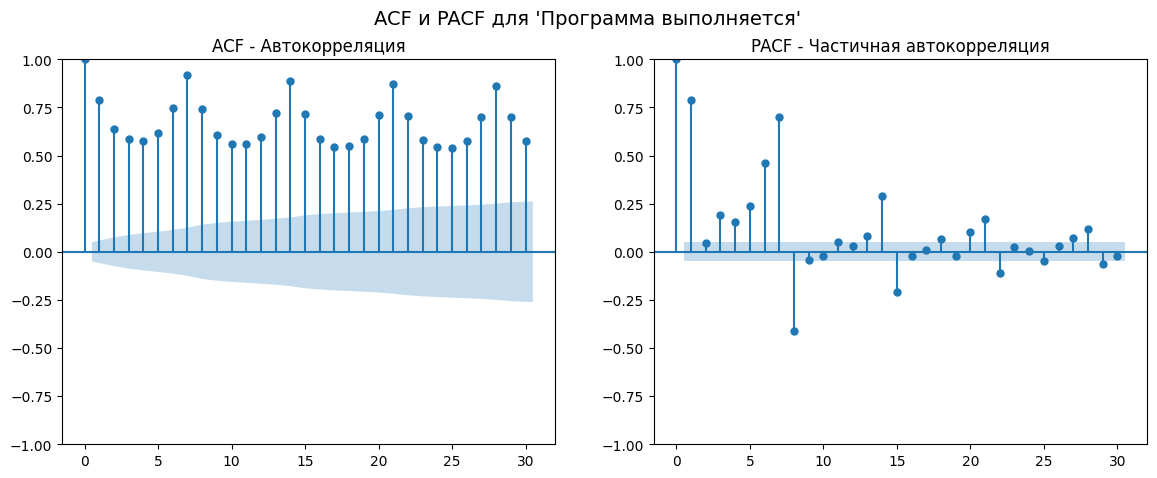

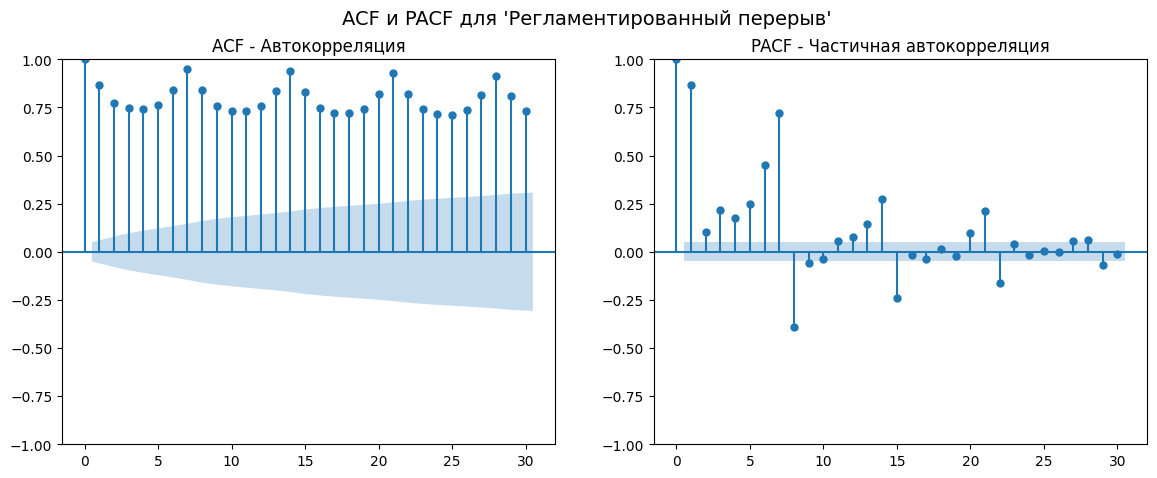

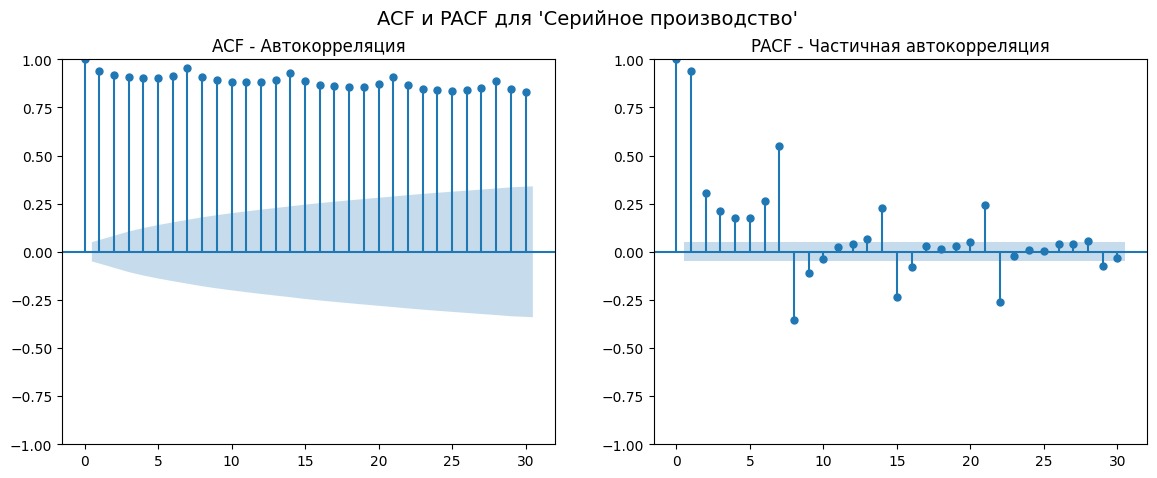

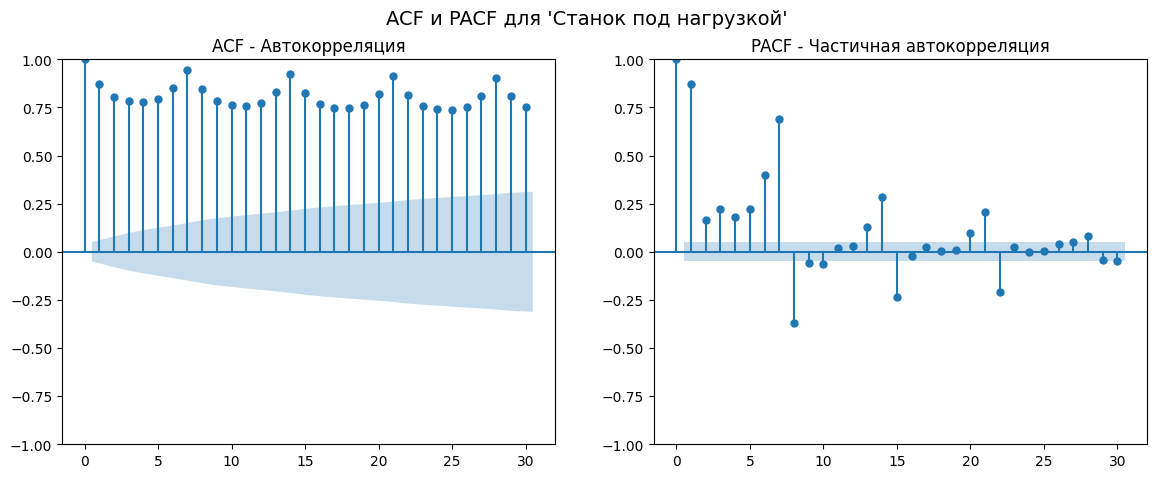

In [59]:
built_acf_and_pacf(df_cleaned, target_columns)
built_acf_and_pacf(df_cleaned, exog_variables_dict['OEE'])

In [60]:
import holidays
import numpy as np
from scipy.interpolate import interp1d

In [61]:
def preprocess_data(data, target, exog_columns=None, lag_start=1, lag_end=60, test_size=0.2):
    data = pd.DataFrame(data.copy())

# Лаговые признаки
    lag_steps = [1, 7, 14, 30, 60]
    for lag in lag_steps:
        data[f"{target}_lag_{lag}"] = data[target].shift(lag)
        if exog_columns is not None:
            for col in exog_columns:
                data[f"{col}_lag_{lag}"] = data[col].shift(lag)
        else:
            for col in data.drop(target, axis=1).columns.to_list():
                data[f"{col}_lag_{lag}"] = data[col].shift(lag)

    # Скользящие средние и стандартное отклонение
    window_sizes = [7, 14, 30, 60]
    for window in window_sizes:
        data[f"{target}_mean_{window}"] = data[target].rolling(window=window).mean()
        data[f"{target}_std_{window}"] = data[target].rolling(window=window).std()
        if exog_columns is not None:
            for col in exog_columns:
                data[f"{col}_mean_{window}"] = data[col].rolling(window=window).mean()
                data[f"{col}_std_{window}"] = data[col].rolling(window=window).std()

    # Временные признаки
    data["day_of_week"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)

    # Праздники
    ru_holidays = holidays.RU(years=data.index.year.unique())
    data["holiday"] = data.index.map(lambda x: 1 if x in ru_holidays else 0)

    # Удаляем NaN
    data.dropna(inplace=True)

    # Разделение на train/test
    size = int(len(data) * (1 - test_size))
    X_train = data.iloc[:size].drop(target, axis=1)
    X_test = data.iloc[size:].drop(target, axis=1)
    y_train = data[target].iloc[:size]
    y_test = data[target].iloc[size:]

    return X_train, X_test, y_train, y_test


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [63]:
TEST_SIZE = 0.2
LAG = 60
X_train, X_test, y_train, y_test = preprocess_data(
    df_cleaned, target='OEE', lag_end=LAG, exog_columns=exog_variables_dict['OEE'], test_size=TEST_SIZE
)

In [79]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# --- Фиксируем seed для воспроизводимости ---
RANDOM_SEED = 42

# --- Параметры кросс-валидации (5 фолдов для временных рядов) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- Список моделей и их параметров для подбора ---
models = {
    "LinearRegression": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", LinearRegression())
        ]),
        "params": {}  # У линейной регрессии нет гиперпараметров
    },
    "DecisionTreeRegressor": {
        "pipeline": Pipeline([
            # ("scaler", StandardScaler()),
            ("model", DecisionTreeRegressor(random_state=RANDOM_SEED))
        ]),
        "params": {
            "model__max_depth": [3, 5, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "RandomForestRegressor": {
        "pipeline": Pipeline([
            # ("scaler", StandardScaler()),
            ("model", RandomForestRegressor(random_state=RANDOM_SEED))
        ]),
        "params": {
            "model__n_estimators": [50, 100, 150, 200],
            "model__max_depth": [5, 7, 9, 11],
            "model__min_samples_split": [2, 4, 6, 8],
            "model__min_samples_leaf": [1, 2, 3, 4]
        }
    },
    "CatBoostRegressor": {
        "pipeline": Pipeline([
            # ("scaler", StandardScaler()),
            ("model", CatBoostRegressor(verbose=2, random_seed=RANDOM_SEED, has_time=True))
        ]),
        "params": {
            "model__depth": [2, 4, 6],
            "model__iterations": [200, 300],
            "model__learning_rate": [0.03, 0.05],
            "model__l2_leaf_reg": [3, 5, 7]
        }
    },
    # "SVR": {
    #     "pipeline": Pipeline([
    #         # ("scaler", StandardScaler()),  # Нормализация данных перед SVM
    #         ("model", SVR())
    #     ]),
    #     "params": {
    #         "model__kernel": ["linear", "rbf"],
    #         "model__C": [0.1, 1],
    #         "model__epsilon": [0.01, 0.1, 1]
    #     }
    # }
}

# --- Хранение результатов ---
results = []

# --- Обучение и подбор гиперпараметров ---
for model_name, model_info in models.items():
    print(f"🔹 Обучаем модель: {model_name}")

    # RandomizedSearchCV для подбора гиперпараметров (быстрее, чем GridSearchCV)
    search = RandomizedSearchCV(
        model_info["pipeline"],
        model_info["params"],
        n_iter=20,  # Количество случайных комбинаций параметров
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        random_state=RANDOM_SEED,  # Фиксируем seed
        verbose=2,
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # --- Предсказания на тесте ---
    preds = best_model.predict(X_test)

    # --- Оценка метрик ---
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "model": model_name,
        "best_params": search.best_params_,
        "MAE": mae,
        "MAPE": mape,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
    })

# --- Вывод результатов ---
# df_results = pd.DataFrame(results).sort_values(by="MAE")
df_results = pd.DataFrame(results)
display(df_results)

# --- Вывод лучших параметров для каждой модели ---
for i in df_results['best_params']:
    print(i)

🔹 Обучаем модель: LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
🔹 Обучаем модель: DecisionTreeRegressor
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔹 Обучаем модель: RandomForestRegressor
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔹 Обучаем модель: CatBoostRegressor
Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.0954124	total: 2.35ms	remaining: 703ms
2:	learn: 0.0912851	total: 6.59ms	remaining: 652ms
4:	learn: 0.0877016	total: 10.4ms	remaining: 612ms
6:	learn: 0.0838628	total: 13.9ms	remaining: 583ms
8:	learn: 0.0807076	total: 17.5ms	remaining: 566ms
10:	learn: 0.0778833	total: 21.2ms	remaining: 556ms
12:	learn: 0.0750738	total: 24.6ms	remaining: 544ms
14:	learn: 0.0730438	total: 28.1ms	remaining: 534ms
16:	learn: 0.0710301	total: 31.7ms	remaining: 528ms
18:	learn: 0.0690863	total: 35.4ms	remaining: 524ms
20:	learn: 0.0673994	total: 39.1ms	remaining: 520ms
22:	learn: 0.0657266	total: 42.6ms	re

,model,best_params,MAE,MAPE,MSE,RMSE,R2
0,LinearRegression,{},0.093877,0.216753,0.025614,0.160045,-6.586611
1,DecisionTreeRegressor,"{'model__min_samples_split': 2, 'model__min_sa...",0.035294,0.077863,0.002008,0.044815,0.405142
2,RandomForestRegressor,"{'model__n_estimators': 200, 'model__min_sampl...",0.034445,0.073914,0.001766,0.042018,0.477076
3,CatBoostRegressor,"{'model__learning_rate': 0.05, 'model__l2_leaf...",0.020347,0.044995,0.000749,0.027369,0.778143


{}
{'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5}
{'model__n_estimators': 200, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 11}
{'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 300, 'model__depth': 4}


In [80]:
display(df_results)

# --- Вывод лучших параметров для каждой модели ---
for i in range(df_results.shape[0]):
    print(f"Лучшие параметры для {df_results.iloc[i, 0]}: {df_results.iloc[i, 1]}")


# --- Вывод лучших параметров для каждой модели ---
    # print(f"Лучшие параметры для {}")

,model,best_params,MAE,MAPE,MSE,RMSE,R2
0,LinearRegression,{},0.093877,0.216753,0.025614,0.160045,-6.586611
1,DecisionTreeRegressor,"{'model__min_samples_split': 2, 'model__min_sa...",0.035294,0.077863,0.002008,0.044815,0.405142
2,RandomForestRegressor,"{'model__n_estimators': 200, 'model__min_sampl...",0.034445,0.073914,0.001766,0.042018,0.477076
3,CatBoostRegressor,"{'model__learning_rate': 0.05, 'model__l2_leaf...",0.020347,0.044995,0.000749,0.027369,0.778143


Лучшие параметры для LinearRegression: {}
Лучшие параметры для DecisionTreeRegressor: {'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5}
Лучшие параметры для RandomForestRegressor: {'model__n_estimators': 200, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 11}
Лучшие параметры для CatBoostRegressor: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 300, 'model__depth': 4}


In [ ]:
# rf_params = next(item["best_params"] for item in results if item["model"] == "CatBoostRegressor")
# print(rf_params)
# bm_params = df_results['best_params'][2]
# bm_name = df_results['model'][2]

In [66]:
# bm_name

In [77]:
bm_params = {
        'learning_rate': 0.05,
        'l2_leaf_reg': 3,
        'iterations': 300,
        'depth': 4
    }
bm_name = 'CatBoostRegressor'
print(bm_params)

{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4}


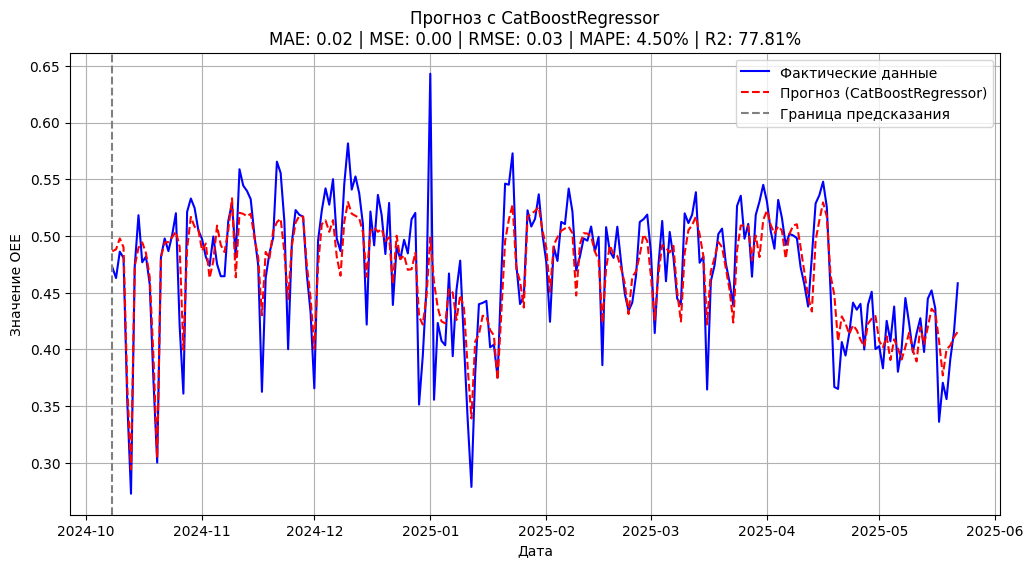

In [78]:
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

RANDOM_SEED = 42
# --- Убираем префикс "model__" из bm_params ---
cleaned_bm_params = {k.replace("model__", ""): v for k, v in bm_params.items()}

# --- Обучение модели с лучшими параметрами через Pipeline ---
best_pipeline = Pipeline([
    # ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(**cleaned_bm_params, verbose=0, random_seed=RANDOM_SEED, has_time=True, thread_count=-1))
    # ("model", SVR(**cleaned_bm_params))
])

best_pipeline.fit(X_train, y_train)  # Обучаем

# --- Прогнозирование ---
final_preds = best_pipeline.predict(X_test)

# --- Вычисление метрик ---
mae = mean_absolute_error(y_test, final_preds)
mse = mean_squared_error(y_test, final_preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

# --- Визуализация прогноза ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические данные", color="blue")
plt.plot(y_test.index, final_preds, label=f"Прогноз ({bm_name})", color="red", linestyle="dashed")

plt.axvline(x=y_test.index[0], color="gray", linestyle="--", label="Граница предсказания")
plt.legend()
plt.title(f"Прогноз с {bm_name}\n"
          f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2%} | R2: {r2:.2%}")
plt.xlabel("Дата")
plt.ylabel("Значение OEE")
plt.grid(True)
plt.show()

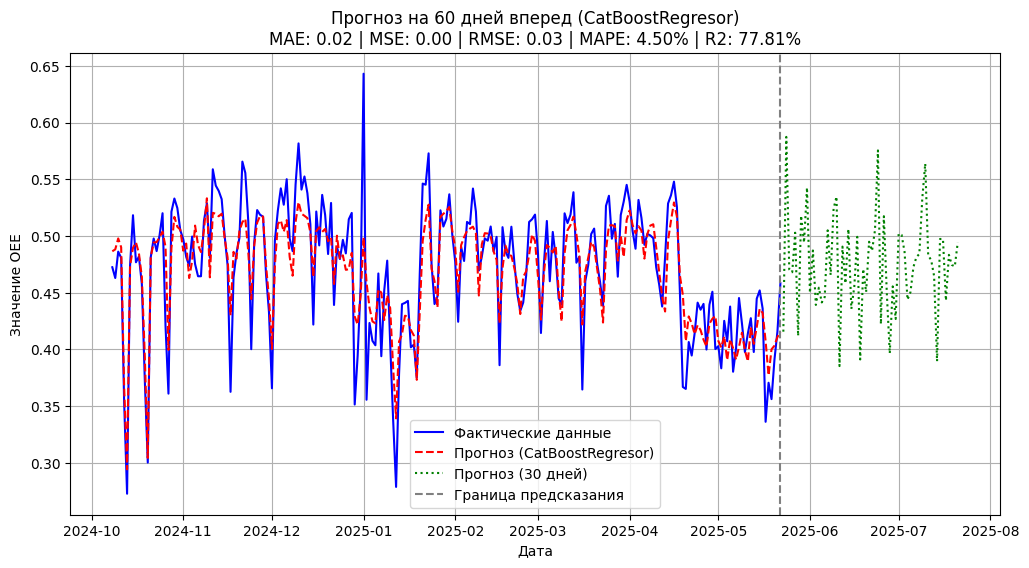

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# --- Итеративный прогноз на 30 дней вперед ---
forecast_horizon = 60
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

# Копируем последнюю строку X_test как основу для прогнозирования
last_known_data = X_test.iloc[-1:].copy()
future_preds = []

for _ in range(forecast_horizon):
    next_pred = best_pipeline.predict(last_known_data)[0]  # Прогноз следующего дня
    future_preds.append(next_pred)
    
    # Сдвигаем лаги: удаляем самый старый лаг и добавляем новое предсказанное значение
    last_known_data = last_known_data.shift(-1, axis=1)  # Сдвиг всех лагов
    last_known_data.iloc[:, -1] = next_pred  # Добавляем новый прогноз в самый свежий лаг

# --- Визуализация прогноза ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические данные", color="blue")
plt.plot(y_test.index, final_preds, label="Прогноз (CatBoostRegresor)", color="red", linestyle="dashed")
plt.plot(future_dates, future_preds, label="Прогноз (30 дней)", color="green", linestyle="dotted")

plt.axvline(x=y_test.index[-1], color="gray", linestyle="--", label="Граница предсказания")
plt.legend()
plt.title(f"Прогноз на 60 дней вперед (CatBoostRegresor)\n"
          f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2%} | R2: {r2:.2%}")
plt.xlabel("Дата")
plt.ylabel("Значение OEE")
plt.grid(True)
plt.show()


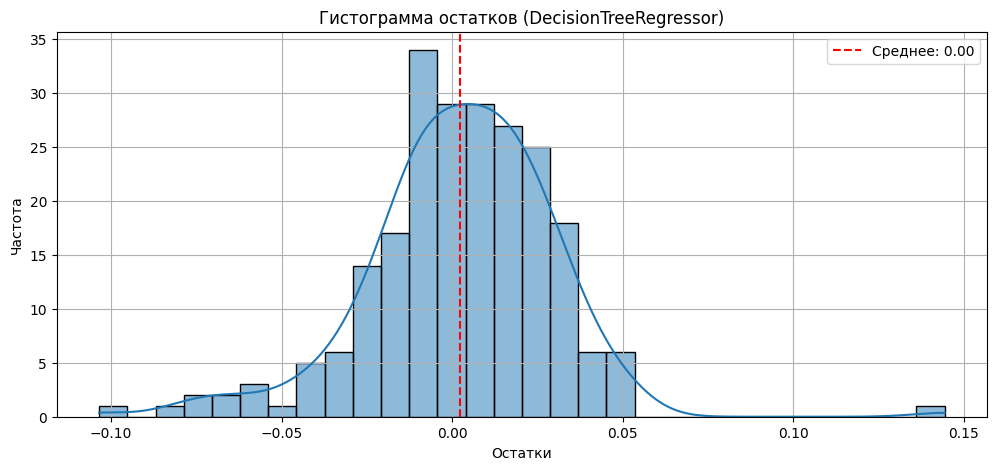

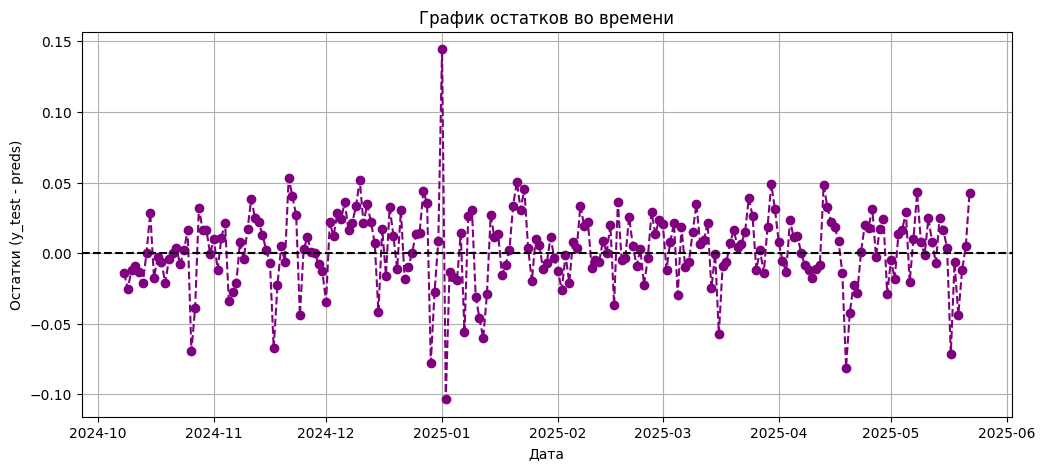

<Figure size 1200x500 with 0 Axes>

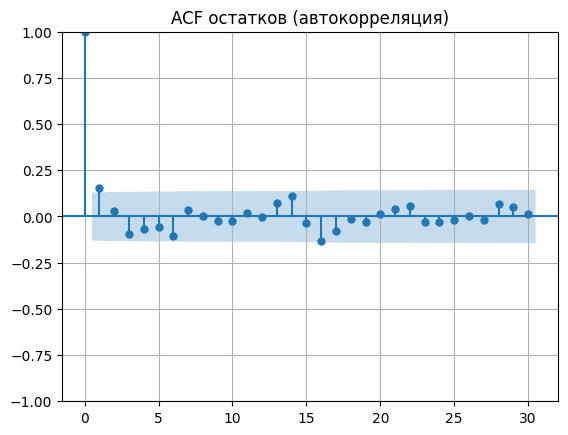

In [ ]:
# --- Анализ остатков ---
residuals = y_test - final_preds

# --- Гистограмма остатков ---
plt.figure(figsize=(12, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(residuals.mean(), color="red", linestyle="dashed", label=f"Среднее: {residuals.mean():.2f}")
plt.legend()
plt.title("Гистограмма остатков (DecisionTreeRegressor)")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

# --- График остатков во времени ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, residuals, marker="o", linestyle="dashed", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.title("График остатков во времени")
plt.xlabel("Дата")
plt.ylabel("Остатки (y_test - preds)")
plt.grid(True)
plt.show()

# --- ACF остатков (автокорреляция) ---
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=30)
plt.title("ACF остатков (автокорреляция)")
plt.grid(True)
plt.show()
